# Class-Conditional diffusion Models on Fashion MNIST

This notebook and the implemantations of the diffusion neural networks are based on the course on diffusion models from huggingface ([see here for huggingface's tutorial](https://huggingface.co/learn/diffusion-course/unit2/3)). 

We initially consider the original implementation as proposed in huggingface's course, and then apply some changes to make this implementation original. In particular, we implement the `AttentionUNet` architecture by adding some attention gates to the original Unet architecture similar to huggingface's `UNet2DModel` architecture.

We also implement manually the linear noise scheduler used by DDPMs, alongside with the corresponding sampling method.
Finally, we compare the proposed implementation to huggingface's implementation of DDPM's with their `UNet2DModel` that uses attention gates alongside the Unet architecture.

The notebook is organised as follows:
* 0 - Imports and setup
* 1 - Exploring the Fashion MNIST Dataset
* 2 - Implementing AttentionUNet
* 3 - Noise schedulers
* 4 - Define score model and class-conditioned model
* 5 - Training the model
* 6 - Inference
* 7 - Implementation using Huggingface 

## 0 - Imports and setup

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

/home/atlorente/Documents/codes/research/research-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1 - Exploring the Fashion MNIST Dataset
In this section we will explore the FashionMNIST Dataset : We will visualise some samples and we will ensure that the different classes are evenly distributed.

In [2]:
training_set = torchvision.datasets.FashionMNIST(root="Fashionmnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
validation_set = torchvision.datasets.FashionMNIST(root="Fashionmnist/", train=False, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
train_dataloader = DataLoader(training_set, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=8, shuffle=False)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 5, 3, 0, 6, 6, 8, 6])


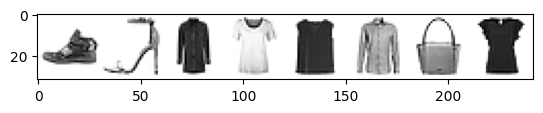

In [4]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [5]:
x.min(), x.max()

(tensor(0.), tensor(1.))

Each image is a greyscale 28px by 28px drawing of a piece of clothe, with values ranging from 0 to 1.

In [6]:
class_tot = torch.zeros(10)
for _, y in tqdm(train_dataloader):
    for i in range(10):
        class_tot[i] += torch.sum(1.0*(y==i))

class_tot

100%|██████████████████████████████████████| 7500/7500 [00:14<00:00, 534.26it/s]


tensor([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.])

The classes of the training set are balanced with 6000 samples for each class.

## 2 - The models : BasicUnet - AttentionUnet - UNet2DModel

We need a model that takes 28px noisy images as inputs and outputs a prediction of the same shape. A popular choice for such image-to-image regression tasks is the Unet architecture. [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597), a UNet consists of a 'constricting path' through which data is compressed down and an 'expanding path' through which it expands back up to the original dimension (similar to an autoencoder) but also features skip connections that allow for information and gradients to flow across at different levels.

The basic features of the Unet architecture are the convolution layers, activation layers, downsampling and upsampling layers. The `BasicUNet` architecure proposed in this [tutorial](https://huggingface.co/learn/diffusion-course/unit1/3) from hugginface is made up exclusively of such layers. We will use this implementation as a starting point, and improve it through the addition of attention gates.

In [7]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels : int=1, out_channels:int =1):
        """
        in_channels :int - number of channels in the input tensor
        out_channels :int - number of channels in the output tensor
        """
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """
        Inputs
        x : torch.Tensor - input tensor of shape [bs, in_channels, h, w]
        Outputs
        out : torch.Tensor - output tensor of shape [bs, out_channels, h, w]
        """
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function

        return x

We can verify that the output shape is the same as the input, as we expect:

In [8]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [9]:
sum([p.numel() for p in net.parameters()])

309057

This network has just over 300,000 parameters.

We now apply some modifications to this original Unet architecture in order to harness the power of attention mechanisms. These modifications have led to the addition of attention gates in the skip-layer parts of the neural network. In this instance, we implement the attention gates by replacing the fully-connected layers used in attention gates by convolution layers as is usually done when processing images.

In [10]:
class AttentionGate(nn.Module):
    def __init__(self, F_g :int , F_l : int, F_int : int):
        """
        F_g : int - features of the gated signal
        F_l : int - features of the Local Feature Map
        F_int : int - features in the feature space used to compute the attention scores.
        """
        super(AttentionGate, self).__init__()
        # Query layer
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int))
        # Key layer
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int))
        # Attention weight layer
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()) # Note that we used a convolutional layer followed by a sigmoid activation
        # This is analogous to the softmax operation for regular attention layers.
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g : torch.Tensor, x : torch.Tensor) -> torch.Tensor:
        """
        inputs : 
        - g : gated signal of shape [batch_size, F_g, h, w]
        - x : local feature map of shape [batch_size, F_l, h, w]

        outputs :
        - out : the local feature map multiplied by the attention weights, of shape [batch_size, F_l, h, w]
        """
        # Compute the queries
        g1 = self.W_g(g)
        # Compute the keys
        x1 = self.W_x(x)
        # We compute the compatibility score between queries and keys
        psi = self.relu(g1 + x1)
        # Compute the Attention Weights (psi)
        psi = self.psi(psi)
        # The attention weights multiplied with the value x to produce the final output
        return x * psi

In [11]:
att = AttentionGate(32,32,16)
x = torch.rand(8, 32, 28, 28)
att(x, x).shape

torch.Size([8, 32, 28, 28])

Our output is of the expected shape i.e. the shape of the input variable and gated signal.
Finally we integrate the AttentionGate within the Unet Architecture.

In [12]:
class AttentionUNet(nn.Module):
    """Improved UNet implementation modified to include attention mechanisms."""
    def __init__(self, in_channels : int =1, out_channels : int =1):
        """
        in_channels :int - number of channels in the input tensor
        out_channels :int - number of channels in the output tensor
        """
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.att_layers = torch.nn.ModuleList([
            AttentionGate(F_g=64, F_l=64, F_int=32),
            AttentionGate(F_g=32, F_l=32, F_int=16),
        ]) # only two are needed here since we only have 2 skip layers in this case
        
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """
        Inputs
        x : torch.Tensor - input tensor of shape [bs, in_channels, h, w]
        Outputs
        out : torch.Tensor - output tensor of shape [bs, out_channels, h, w]
        """
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x = self.att_layers[i-1](x, h.pop()) # Attention gate between upscaled feature and skip connection
            x = self.act(l(x)) # Through the layer and the activation function
        return x

In [13]:
att_net = AttentionUNet()
x = torch.rand(8, 1, 28, 28)
att_net(x).shape

torch.Size([8, 1, 28, 28])

In [14]:
sum([p.numel() for p in att_net.parameters()])

314519

We have slightly increased the number of parameters in the model, though not to a significant level. We can also observe that the output is of the same shape as the inputs.

## 3 - Noise schedulers

The idea behind diffusion models is that the process through which an image is degraded by noise can be modeled by a diffusion equation 

$d\mathbf{x} = f(\mathbf{x}, t) dt + g(t) d\mathbf{w}$,<br><br> 
where $f$ is the drift, and $g$ is the diffusion. Choosing $f = 0$ for instance would give us a noise model where Gaussian noise will be continuously added to $\mathbf{x}$, eventually approaching pure Gaussian noise.
DDPMs, choose the following $f(\mathbf{x}, t) = -1/2 \beta(t) \mathbf{x}$, and $g(t) = \sqrt{\beta(t)}$, where $\beta$ is typically linear.


The two ideas of diffusion models is to invert the aforementioned SDE through Anderson's theorem leading to :
$d\mathbf{x} =  (f(\mathbf{x}, t) -g(t)^2\nabla_x \log p_t(\mathbf{x})) dt + g(t) d\tilde{\mathbf{w}}$,<br><br> 

and to learn the score function i.e. $\nabla_x \log p_t(\mathbf{x})$ with a neural network $s_\theta$

When discretising this scheme, we obtain the following scheme for generating noise :
$\mathbf{x}_i =  \sqrt{1-\beta_i} \mathbf{x}_{i-1} + \sqrt{\beta_i} \mathbf{z}$.

That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule.
We have a formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

We will first take a look at huggingface's DDPMScheduler to implement the linear DDPM noise scheduler to handle the noise simulation and then implement it ourselves in the class `corruption_DDPM_ours`.

In [15]:
def corrupt_DDPM(x : torch.Tensor, t: torch.Tensor, t_max : int) -> torch.Tensor:
  """Corrupt the input `x` by mixing it with noise according to huggingface's DDPM scheduler
  Inputs : 
  x : torch.Tensor - non-noisy image of shape [bs, 1, h, w]
  t: torch.Tensor - timestep at which we apply noise. shape [bs]
  t_max : int - maximum number of timesteps. 

  Outputs :
  out : noisy image of shape [bs, 1, h, w]
  """
  xb = x
  scheduler = DDPMScheduler(num_train_timesteps=t_max)
  noise = torch.randn_like(x)
  return scheduler.add_noise(xb, noise, t)

We now visuallise the DDPM scheduler

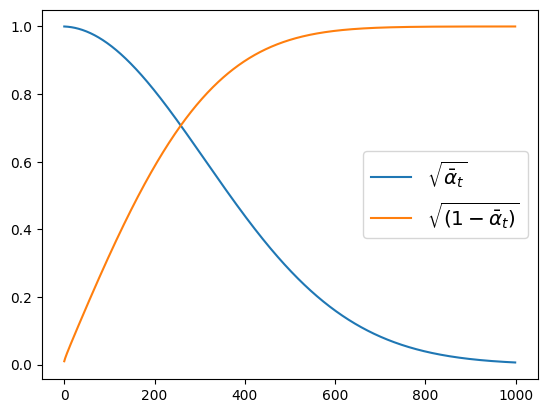

In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Text(0.5, 1.0, 'Noisy X (-- amount increases -->)')

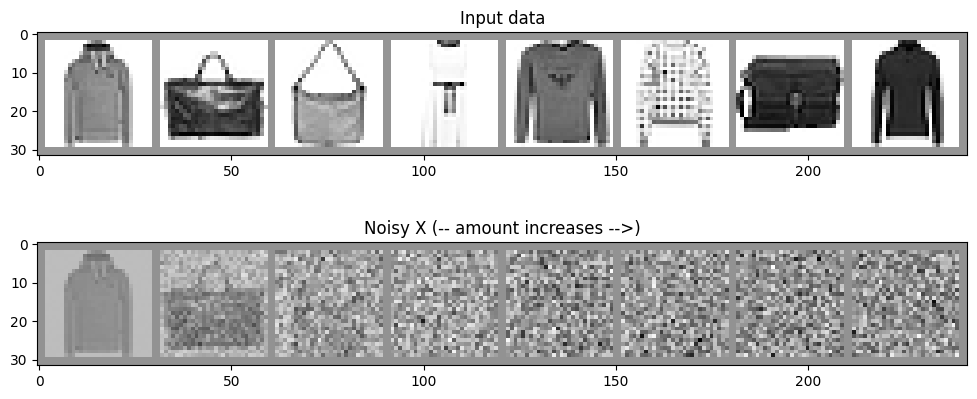

In [17]:
x, y = next(iter(train_dataloader))
t_max = 1000
x = x * 2. - 1.

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
t = (t_max-1)*torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
t = t.long()
noised_x = corrupt_DDPM(x, t, t_max)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noised_x[:8])[0].detach().cpu(),  cmap='Greys')
axs[1].set_title('Noisy X (-- amount increases -->)')


We can implement the scheduler ourselves using the definition of the DDPM scheduler given by the original paper. This beta  schedule is essentially a linear scheduler :

In [18]:
beta = torch.linspace(0, 0.02, 1000)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

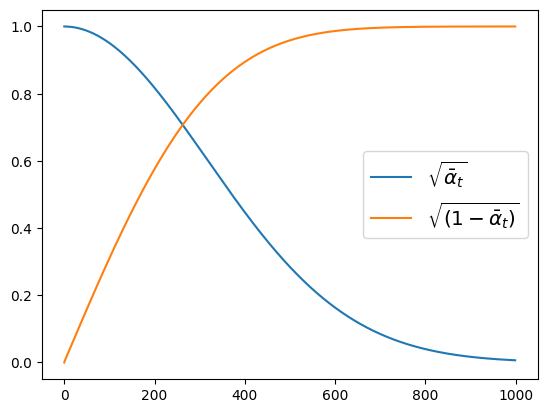

In [19]:
plt.plot(alpha_hat ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - alpha_hat )** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

As we can see, we obtain the same cumulated product as the one from Huggingface. Now we just need to implement the noise degradation. 

In [20]:
def corrupt_DDPM_our(x : torch.Tensor, t : torch.Tensor, t_max : int) -> torch.Tensor:
    """Corrupt the input `x` by mixing it with noise according to our DDPM scheduler
    Inputs : 
    x : torch.Tensor - non-noisy image of shape [bs, 1, h, w]
    t: torch.Tensor - timestep at which we apply noise. shape [bs]
    t_max : int - maximum number of timesteps. 
    
    Outputs :
    out : noisy image of shape [bs, 1, h, w]
    """
    x_noi = x
    beta = torch.linspace(1e-6, 0.02, t_max)
    alpha = 1 - beta
    alpha_hat = torch.cumprod(alpha, dim=0)
    noise = torch.randn_like(x)
    amount = alpha_hat[t]
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    x_noi = x_noi * torch.sqrt(amount) + noise * torch.sqrt(1 - amount)
    return x_noi

Text(0.5, 1.0, 'Noisy X (-- amount increases -->)')

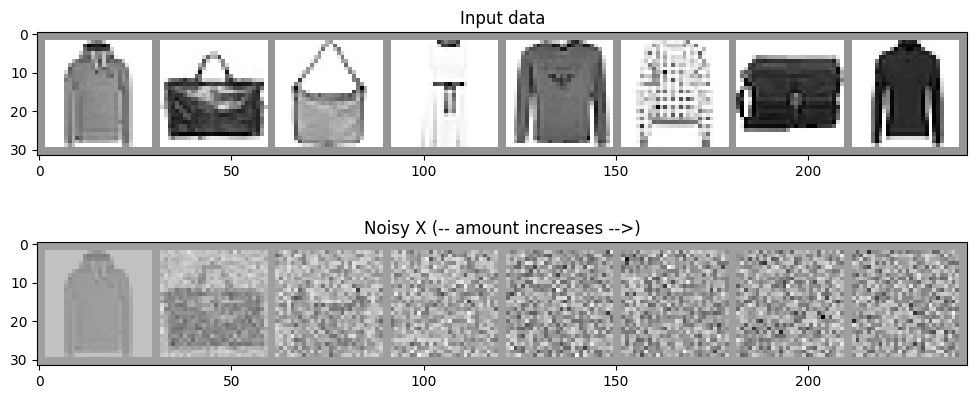

In [21]:
# x, y = next(iter(train_dataloader))
t_max = 1000

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
t = (t_max-1)*torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
t = t.long()
noised_x = corrupt_DDPM_our(x, t, t_max)

# Show noisy version
axs[1].imshow(torchvision.utils.make_grid(noised_x[:8])[0].detach().cpu(),  cmap='Greys')
axs[1].set_title('Noisy X (-- amount increases -->)')

We observe exactly the same pattern as the one for the DDPM scheduler. The only issue with implementing the DDPM manually is that it might be time consuming and potentially less optimal compared to using Huggingface's. But this toy example does a good showcase of how the DDPM scheduler is implemented.

Initially, the noisy x is mostly x (sqrt_alpha_prod ~= 1) but over time the contribution of x drops and the noise component increases. This scheduler gets the image noisy relatively quickly.

## 4 - Defining class for applying noise and applying the class conditionning

In [22]:
class corruption_DDPM_ours(nn.Module):
    def __init__(self, device : torch.device, t_max: int, eps :  float = 1e-4, beta_max : float = 0.02):
        """
        Class to apply the DDPM noise corruption
        device : torch.device - device where the computation is performed
        t_max : int - maximum number of timesteps. 
        eps : float - minimum value of beta (must be non-zero to avoid dividing by 0)
        beta_max : float - maximum vale of beta in the DDPM scheduler
        """
        super().__init__()
        self.device = device
        self.t_max = t_max
        self.beta = torch.linspace(eps, beta_max, self.t_max).to(self.device)
        self.alpha = (1 - self.beta).to(self.device)
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).to(self.device)

    def forward(self, noise : torch.Tensor, x : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        """Corrupt the input `x` by mixing it with `noise` according to the DDPM scheduler
        Inputs : 
        x : torch.Tensor - non-noisy image of shape [bs, 1, h, w]
        t: torch.Tensor - timestep at which we apply noise. shape [bs]
        
        Outputs :
        out : noisy image of shape [bs, 1, h, w]
        """
        amount = self.alpha_hat[t]
        amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
        return x * torch.sqrt(amount) + noise * torch.sqrt(1 - amount)

We now need to modify the architecture to adapt it to take into account 2 things :
- The timestep : By definition score models are time-dependent. This also allows the network to learn how to work at different time periods. This is added through an embedding layer as another channel of the image.
- The class : our goal is to generate data from different classes. We need to include the class information in order to potentially obtain a class-dependent score model. This information is also added through an embedding layer as another channel of the image.

In [23]:
class ClassConditionedUnet_ours(nn.Module):
  def __init__(self, model, num_classes : int = 10, class_emb_size : int=4, t_max : int = 1000, t_emb : int = 5):
    """
    num_classes : number of classes in the classifier
    class_emb_size : size of the embedding for the class input
    t_max : number of timesteps
    t_emb : size of the embedding for the time input
    """
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = model

    self.t_embed = nn.Embedding(t_max, t_emb)  

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x : torch.Tensor, t: torch.Tensor, class_labels: torch.Tensor) -> torch.Tensor:
    """
    Computes the class and time conditioned output of the neural network

    Inputs : 
    x : torch tensor representing the input noisy image - of shape [bs, 1, h, w]
    t : torch tensor representing timesteps for image x - of shape [bs]
    class_labels : torch tensor containing the class labels - of shape [bs]
    """
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    t_cond = self.t_embed(t).view(bs, -1, 1, 1).expand(bs, -1, w, h)
    
    net_input = torch.cat((x, class_cond, t_cond), 1)
    # net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input) # (bs, 1, 28, 28)

## 5 - Training the network

Given a corrupted input noisy_x the model should output its best guess for what the noise looks like. We will compare this to the actual value via the mean squared error.

We can now have a go at training the network.
- Get a batch of data
- Corrupt it by random amounts
- Feed it through the model
- Compare the model predictions with the clean images to calculate our loss
- Update the model's parameters accordingly.

In [24]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 15

# Create the network
t_max = 1000
net = AttentionUNet(in_channels = 10)
model = ClassConditionedUnet_ours(net)
model = model.to(device)
corrupt = corruption_DDPM_ours(device, t_max)

# Our loss function
loss_fn = nn.MSELoss() 
# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

# Keeping a record of the losses for later viewing
losses = []

100%|█████████████████████████████████████████| 469/469 [01:13<00:00,  6.38it/s]


Finished epoch 0. Average of the last 100 loss values: 0.424359


100%|█████████████████████████████████████████| 469/469 [01:13<00:00,  6.37it/s]


Finished epoch 1. Average of the last 100 loss values: 0.386009


100%|█████████████████████████████████████████| 469/469 [01:15<00:00,  6.18it/s]


Finished epoch 2. Average of the last 100 loss values: 0.380394


100%|█████████████████████████████████████████| 469/469 [01:17<00:00,  6.07it/s]


Finished epoch 3. Average of the last 100 loss values: 0.377869


100%|█████████████████████████████████████████| 469/469 [01:18<00:00,  5.99it/s]


Finished epoch 4. Average of the last 100 loss values: 0.375569


100%|█████████████████████████████████████████| 469/469 [01:19<00:00,  5.90it/s]


Finished epoch 5. Average of the last 100 loss values: 0.373904


100%|█████████████████████████████████████████| 469/469 [01:20<00:00,  5.85it/s]


Finished epoch 6. Average of the last 100 loss values: 0.372942


100%|█████████████████████████████████████████| 469/469 [01:22<00:00,  5.70it/s]


Finished epoch 7. Average of the last 100 loss values: 0.372170


100%|█████████████████████████████████████████| 469/469 [01:22<00:00,  5.65it/s]


Finished epoch 8. Average of the last 100 loss values: 0.371923


100%|█████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s]


Finished epoch 9. Average of the last 100 loss values: 0.371895


100%|█████████████████████████████████████████| 469/469 [01:25<00:00,  5.47it/s]


Finished epoch 10. Average of the last 100 loss values: 0.370326


100%|█████████████████████████████████████████| 469/469 [01:25<00:00,  5.47it/s]


Finished epoch 11. Average of the last 100 loss values: 0.369744


100%|█████████████████████████████████████████| 469/469 [01:26<00:00,  5.43it/s]


Finished epoch 12. Average of the last 100 loss values: 0.370229


100%|█████████████████████████████████████████| 469/469 [01:27<00:00,  5.36it/s]


Finished epoch 13. Average of the last 100 loss values: 0.369600


100%|█████████████████████████████████████████| 469/469 [01:27<00:00,  5.36it/s]

Finished epoch 14. Average of the last 100 loss values: 0.369836


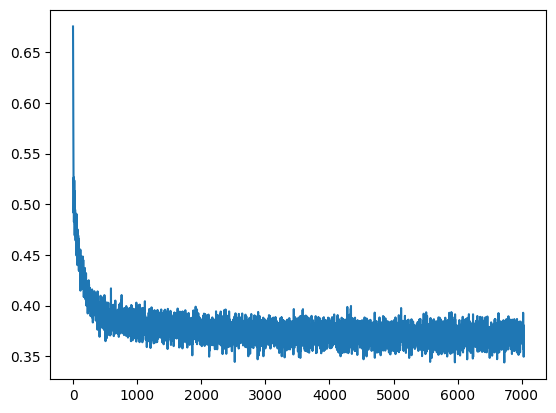

In [26]:
# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # Get some data and prepare the corrupted version
        # Normalise the data and send it to the GPU
        x = x * 2. - 1.
        x = x.to(device) 
        y = y.to(device) 
        t = torch.randint(0, t_max, (x.shape[0],))
        t = t.long()
        t = t.to(device)
        noise = torch.randn_like(x).to(device)

        noisy_x = corrupt(noise,x,t)

        # Get the model prediction
        pred = model(noisy_x, t, y)

        # loss = loss_fn(pred, noise)
        loss = loss_fn(pred, x) 
        # It would normally be the line above where we train the 
        # network to predict noise, BUT, during this toy example, I got significantly better results 
        # in predicting the denoised image
        # and then estimating noise through preds - x_noise
        
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    scheduler.step()
    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [27]:
torch.save(model, './models/cond_fasion_DDPM_ours.pth')

In [25]:
model = torch.load('./models/cond_fasion_DDPM_ours.pth')

Text(0.5, 1.0, 'predicted Noise')

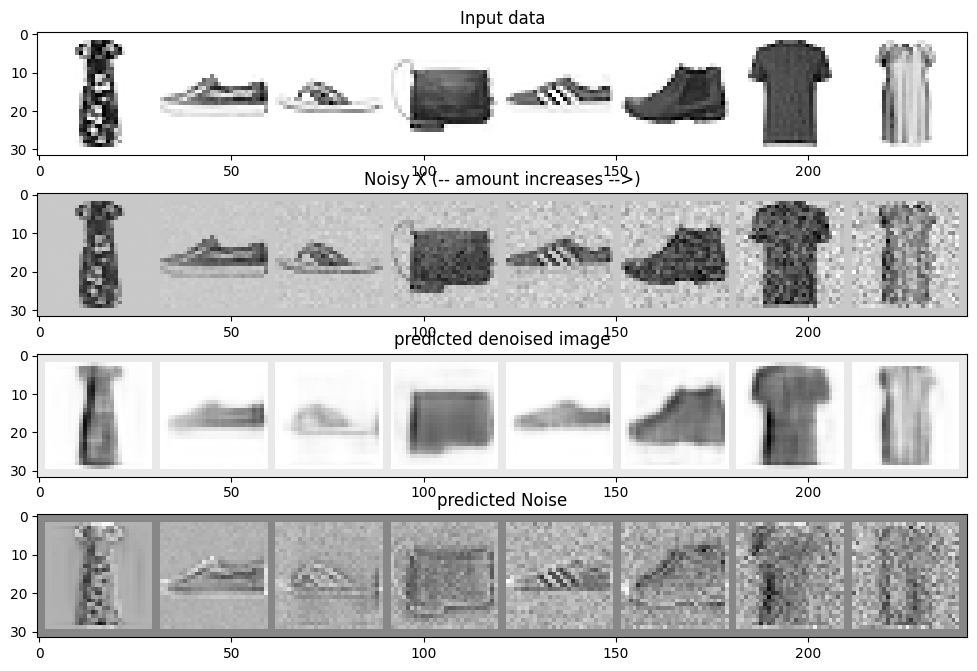

In [26]:
x, y = next(iter(train_dataloader))
t_max = 1000

# Plotting the input data
fig, axs = plt.subplots(4, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x[:8])[0], cmap='Greys')

# Adding noise
t = (t_max-1)*torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
t = t.long()
noised_x = corrupt_DDPM_our(x, t, t_max)

# Show noisy version
axs[1].imshow(torchvision.utils.make_grid(noised_x[:8])[0].detach().cpu(),  cmap='Greys')
axs[1].set_title('Noisy X (-- amount increases -->)')

with torch.no_grad():
    pred = model(noised_x.to(device), t.to(device), y.to(device)).detach().cpu()
# Show noisy version
axs[2].imshow(torchvision.utils.make_grid((pred)[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('predicted denoised image')

# Show noisy version
axs[3].imshow(torchvision.utils.make_grid((pred-noised_x)[:8])[0].detach().cpu(),  cmap='Greys')
axs[3].set_title('predicted Noise')

We can try to see what the model predictions look like by grabbing a batch of data, corrupting it by different amounts and then seeing the models predictions. We can see that for low levels of noise, the denoised image is way too blurry. This is probably going to significantly reduce the DDPM's ability to generate detailed.

## 6 - Sampling

As previously mentionned, DDPMs generate images from noise by inverting the stochastic differential equation through the formula
$d\mathbf{x} =  (f(\mathbf{x}, t) -g(t)^2\nabla_x \log p_t(\mathbf{x})) dt + g(t) d\tilde{\mathbf{w}}$,<br><br> 

Approximating $\nabla_x \log p_t(\mathbf{x})$ with our score model $\epsilon_\theta (\mathbf{x}_{t}, t)$, and discretising the differential equation through time leading in the case of DDPM to the following scheme :

$\mathbf{x}_{t-1} =  \frac{1}{\sqrt{\alpha_t}}\left( \mathbf{x}_{t} - \frac{\beta_t}{\sqrt{1-\hat{\alpha}_t} }\epsilon_\theta (\mathbf{x}_{t}, t) \right)+ \sqrt{\beta_t} \mathbf{z}_t$,<br><br> 

where $\mathbf{z}_t$ is a normally distributed noise.

In [27]:
def sample_ddpm(score_model : nn.Module, classes : torch.Tensor, x_init: torch.Tensor, corrupt : nn.Module, device : torch.device) -> torch.Tensor:
    """
    Sample from a trained DDPM model.
    
    Inputs :
    score_model: nn.Module - The trained score model.
    classes: torch.Tensor - The class labels for conditioning. Of shape [bs]
    x_init: torch.Tensor - Initial noise to start the sampling process. Of shape [bs, 1, h, w]
    corrupt: nn.Module - The corruption schedule used in training.
    device: torch.device - The device to perform computation on.
        
    Outputs:
    out : A generated sample.
    """
    # Initialize with random Gaussian noise
    x_t = x_init
    
    beta = corrupt.beta
    alpha = corrupt.alpha
    alpha_hat = corrupt.alpha_hat
    
    with torch.no_grad():
        for t in tqdm(reversed(range(corrupt.t_max))):
            t_tensor = torch.full((x_t.shape[0],), t, dtype=torch.long, device=device)
            
            # Predict the denoised image using the score model
            pred_x0 = score_model(x_t, t_tensor, classes)
            
            if t > 0:
                # Calculate the mean of the posterior
                alpha_t = alpha[t]
                alpha_hat_t = alpha_hat[t]
                beta_t = beta[t]
                
                # Estimate the noise (The model we trained only estimated the denoised image, so we need 
                # scale it, and subtract it to the noisy image to estimate the noise)
                epsilon_theta = (x_t - torch.sqrt(alpha_t) * pred_x0) / torch.sqrt(1 - alpha_t)
                
                # Mean of the posterior distribution
                mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_hat_t)) * epsilon_theta)
                
                # Sample from the posterior distribution
                z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
                x_t = mean + torch.sqrt(beta_t) * z
            else:  # No stochasticity left at time 0
                x_t = pred_x0
        
    return x_t

In [28]:
# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
# x = 2*((x-x.min())/(x.max()-x.min())) - 1
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
model = model.eval()
samples = sample_ddpm(model, y, x, corrupt, device)

1000it [00:26, 37.29it/s]


In [29]:
samples.shape

torch.Size([80, 1, 28, 28])

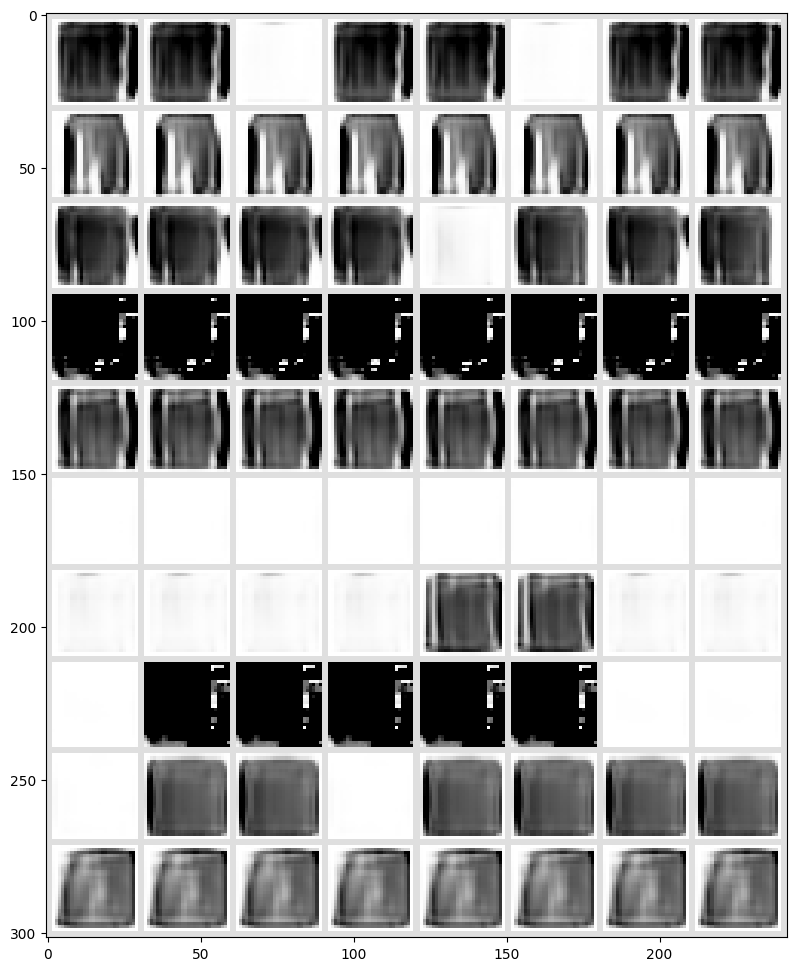

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(samples.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

We can see that unfortunately we end up obtaining images that are too blurry, with too little contrast, and where we barely recognize some sleeves here and there. It does appear that we are far from the desired result. This is presmably explained by the fact that our network is not capable of estimating noise for low levels of noise. This means that we produce a blurry image and we are never capable of generating the details that would eventually lead to good samples. 

It can be assumed that improving the architecture, the noise scheduler (making it so that the images take longer to be overwhelmed by noise) and the embedding of noise are potentially the keys to improving the proposed method.

We will now implement it using Huggingface's tools.

## Comparison To Huggingface's DDPM

In this section we'll take a look at how our toy implementation differs from the approach used in the hugginface tutorial notebook ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)) which ze have adapted to work for fashion MNIST.

We'll see that
*   The diffusers `UNet2DModel` is significantly more advanced than our AttentionUnet
*   The corruption process is handled differently (we used a linear DDPM scheduler, and they use `squaredcos_cap_v2`
*   The model is conditioned on the amount of noise present via timestep conditioning which seems to work better than our simple embedding of time.

### The UNet

The diffusers UNet2DModel model has a number of improvements over our UNet above:

*   GroupNorm applies group normalization to the inputs of each block
*   Dropout layers for smoother training
*   Multiple resnet layers per block (if layers_per_block isn't set to 1)
*   Attention gates are implemented as fully connected layers and added to donwampling and upsampling blocks
*   Conditioning on the timestep is included within the definition of the neural network and doesn't need to be added manually.
*   Downsampling and upsampling blocks with learnable parameters

In [34]:
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

As you can see, a little more going on, but it also has significantly more parameters.

In [35]:
sum([p.numel() for p in model.parameters()]) # 1.7M vs the ~309k parameters of the BasicUNet

1707009

The model used by huggingface shows a significantly higher number of parameters compared to our previously implemented method.

In [36]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [37]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

The scheduler used by their tutorial seems to differ from the one we implemented (being the linear DDPM scheduler).

100%|█████████████████████████████████████████| 469/469 [15:58<00:00,  2.04s/it]


Finished epoch 0. Average of the last 100 loss values: 0.087561


100%|█████████████████████████████████████████| 469/469 [16:04<00:00,  2.06s/it]


Finished epoch 1. Average of the last 100 loss values: 0.079873


100%|█████████████████████████████████████████| 469/469 [16:11<00:00,  2.07s/it]


Finished epoch 2. Average of the last 100 loss values: 0.076677


100%|█████████████████████████████████████████| 469/469 [16:19<00:00,  2.09s/it]


Finished epoch 3. Average of the last 100 loss values: 0.073817


100%|█████████████████████████████████████████| 469/469 [16:24<00:00,  2.10s/it]


Finished epoch 4. Average of the last 100 loss values: 0.072820


100%|█████████████████████████████████████████| 469/469 [16:24<00:00,  2.10s/it]


Finished epoch 5. Average of the last 100 loss values: 0.071586


100%|█████████████████████████████████████████| 469/469 [16:24<00:00,  2.10s/it]


Finished epoch 6. Average of the last 100 loss values: 0.069218


100%|█████████████████████████████████████████| 469/469 [16:35<00:00,  2.12s/it]


Finished epoch 7. Average of the last 100 loss values: 0.069692


100%|█████████████████████████████████████████| 469/469 [16:53<00:00,  2.16s/it]


Finished epoch 8. Average of the last 100 loss values: 0.071194


100%|█████████████████████████████████████████| 469/469 [16:53<00:00,  2.16s/it]

Finished epoch 9. Average of the last 100 loss values: 0.066458


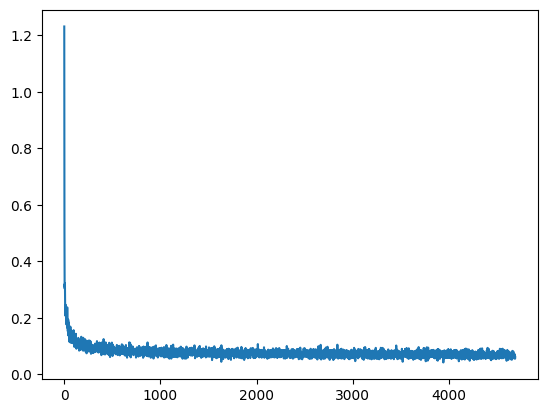

In [38]:
# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [39]:
torch.save(net, './models/cond_fasion_DDPM_HF.pth')

In [40]:
net = torch.load('./models/cond_fasion_DDPM_HF.pth')

1000it [06:44,  2.47it/s]


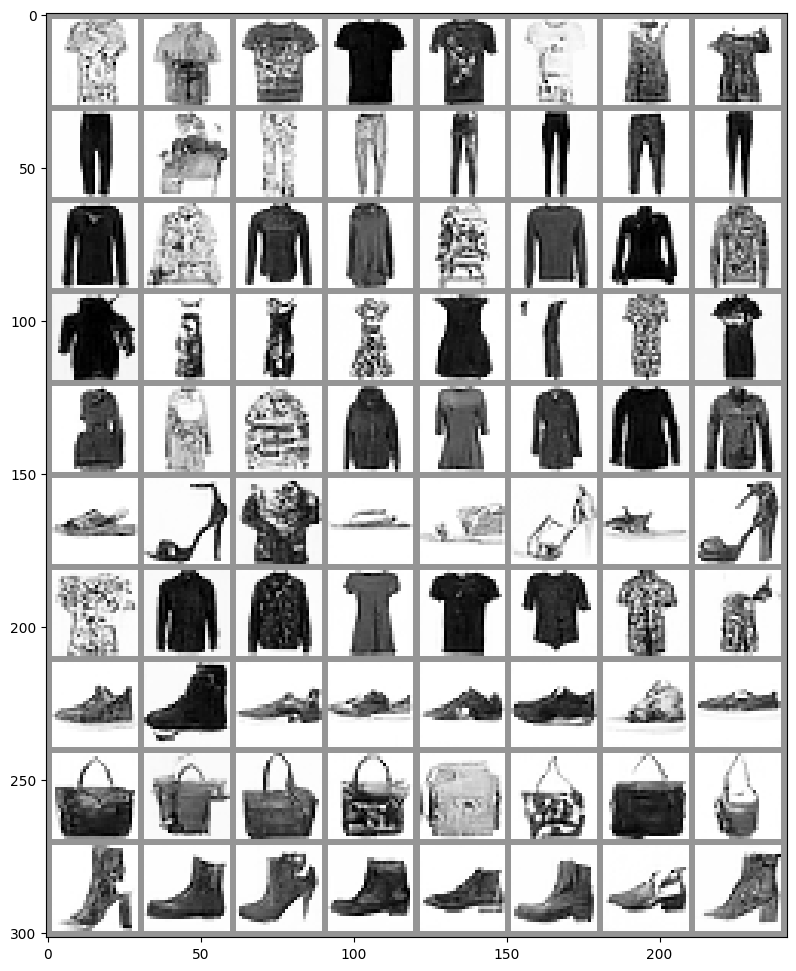

In [41]:
#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample # Huggingface's noise scheduler 
    #has already implemented the integration of the discretised SDE

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

The results obtained with huggingface's methods are very convincing. These can possibly be improved by using the methods included in this paper ['Elucidating the Design Space of Diffusion-Based Generative Models'](https://arxiv.org/abs/2206.00364) which explores all of these components in some detail and makes new recommendations for how to get the best performance.

The improvements observed using Huggingface's tools may be explained through several means :
- Different scheduler
- Better neural network architecture : the Unet used by Huggingface uses resnet blocks instead of simple convolutions. It also implements attention gates (implemented with fully connected layers as opposed to our lightweight version using convolutions) for every downsteam and upstream step.
- Inclusion of the timesteps within the input :  we also included them through an embedding layer, but it is safe to assume that huggingface used more sofisticaded tools for that inclusion.